In [50]:
import torch
from torch import nn


class MNISTAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9),
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

In [51]:
import matplotlib.pyplot as plt
from torch import nn, optim
import numpy as np
from torchvision import datasets, transforms
from tqdm import tqdm

EPOCHS = 20
BATCH_SIZE = 512

tensor_transform = transforms.ToTensor()
dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=tensor_transform
)
loader = torch.utils.data.DataLoader(
    dataset=dataset, batch_size=BATCH_SIZE, shuffle=True
)

model = MNISTAutoEncoder()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=6e-3, weight_decay=1e-8)

losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
model.to(device)

model.train()

for epoch in range(EPOCHS):
    epoch_loss = []
    with tqdm(loader, unit="batch", desc=f"Epoch #{epoch+1}") as pbar:
        for images, _ in pbar:
            images = images.view(-1, 28 * 28).to(device)

            reconstructed = model(images)
            loss = loss_function(reconstructed, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())

            pbar.set_postfix({
                'Avg Loss': f'{sum(epoch_loss) / len(epoch_loss):.4f}'
            })

    losses += epoch_loss

Epoch #20: 100%|██████████| 118/118 [00:01<00:00, 74.15batch/s, Avg Loss=0.0252]


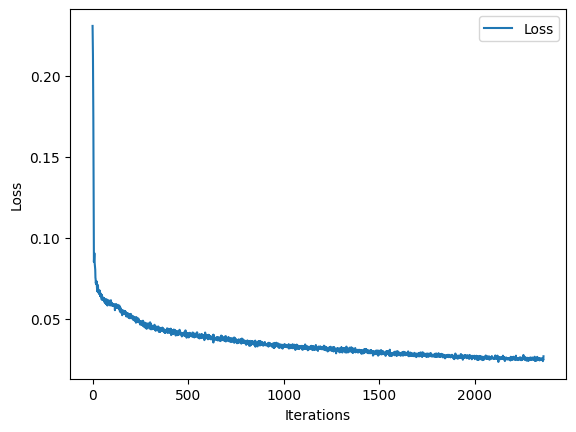

In [52]:
def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

plt.plot(moving_average(losses, 1), label="Loss")
plt.xlabel("Iterations")

plt.ylabel("Loss")
plt.legend()
plt.show()

Test Set: 100%|██████████| 20/20 [00:00<00:00, 51.44batch/s, Avg Loss=0.0248]


Loss: 0.024756


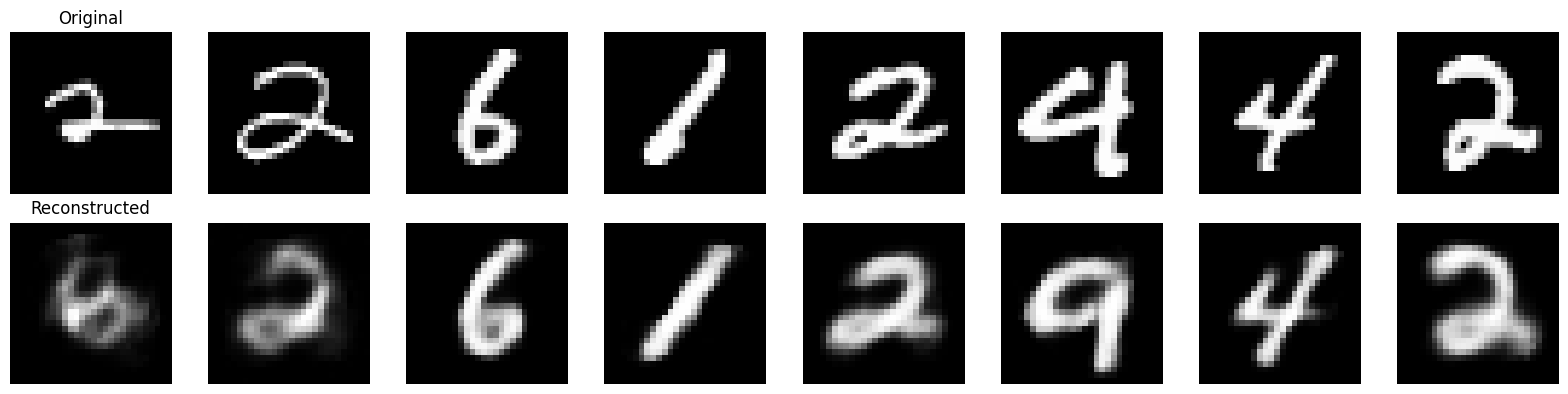

In [53]:
tensor_transform = transforms.ToTensor()
test_dataset = datasets.MNIST(
    root="./data", train=False, download=False, transform=tensor_transform
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

model.eval()

losses = []

with torch.no_grad():
    with tqdm(test_loader, unit="batch", desc=f"Test Set") as pbar:
        for images, _ in pbar:        
            images = images.view(-1, 28 * 28).to(device)

            reconstructed = model(images)
            loss = loss_function(reconstructed, images)

            losses.append(loss.item())

            pbar.set_postfix({
                'Avg Loss': f'{sum(losses) / len(losses):.4f}'
            })

    print(f"Loss: {sum(losses) / len(losses):.6f}")

    images, _ = next(iter(test_loader))

    images = images.view(-1, 28 * 28).to(device)
    reconstructed = model(images)

images = images.view(-1, 28, 28).cpu().detach()
reconstructed = reconstructed.view(-1, 28, 28).cpu().detach()

n = 8

plt.figure(figsize=(n * 2, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.axis("off")
    if i == 0:
        ax.set_title("Original")

for i in range(n):
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i], cmap="gray")
    plt.axis("off")
    if i == 0:
        ax.set_title("Reconstructed")

plt.tight_layout()
plt.show()


In [54]:
from torch import nn


class CIFARAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 3 * 32 * 32),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class CIFARConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # 8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 4x4
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [67]:
import matplotlib.pyplot as plt
from torch import nn, optim
import numpy as np
from torchvision import datasets, transforms
from tqdm import tqdm

EPOCHS = 20
BATCH_SIZE = 512

tensor_transform = transforms.ToTensor()
dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=tensor_transform
)
loader = torch.utils.data.DataLoader(
    dataset=dataset, batch_size=BATCH_SIZE, shuffle=True
)

model = CIFARConvAutoEncoder()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-8)

losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
model.to(device)

model.train()

for epoch in range(EPOCHS):
    epoch_loss = []
    with tqdm(loader, unit="batch", desc=f"Epoch #{epoch+1}") as pbar:
        for images, _ in pbar:
            images = images.to(device)

            reconstructed = model(images)
            loss = loss_function(reconstructed, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())

            pbar.set_postfix({
                'Avg Loss': f'{sum(epoch_loss) / len(epoch_loss):.4f}'
            })

    losses += epoch_loss

Epoch #20: 100%|██████████| 98/98 [00:05<00:00, 16.92batch/s, Avg Loss=0.0023]


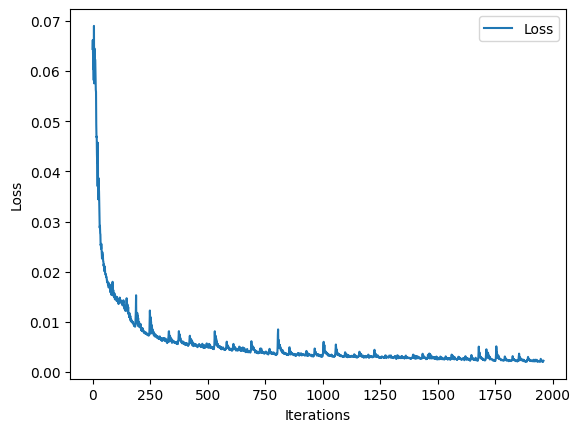

In [68]:
def moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')

plt.plot(moving_average(losses, 1), label="Loss")
plt.xlabel("Iterations")

plt.ylabel("Loss")
plt.legend()
plt.show()

Test Set: 100%|██████████| 20/20 [00:00<00:00, 34.79batch/s, Avg Loss=0.0021]


Loss: 0.002145


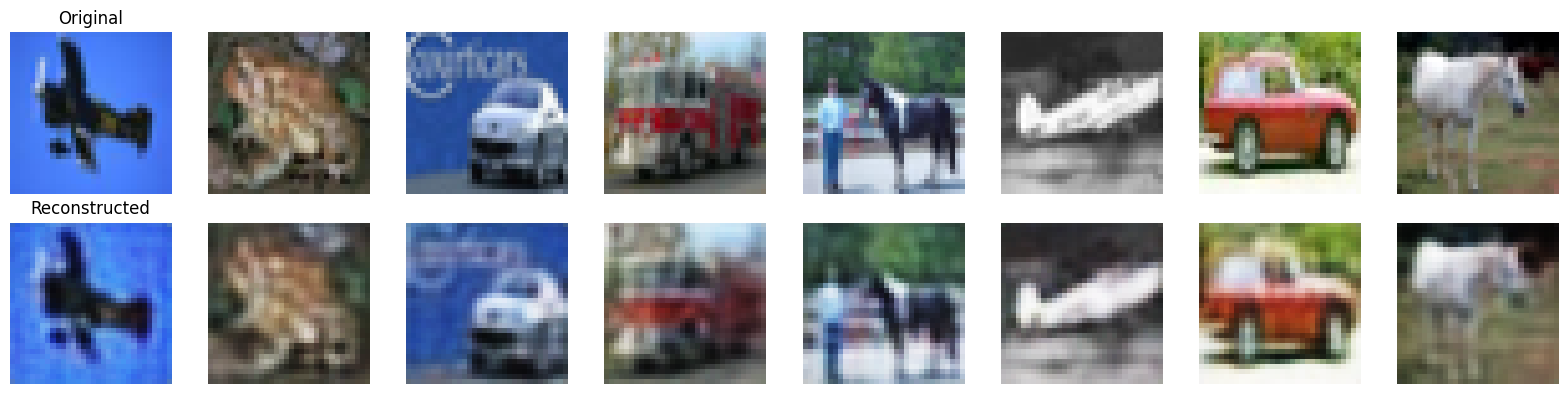

In [88]:
tensor_transform = transforms.ToTensor()
test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=False, transform=tensor_transform
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

model.eval()

losses = []

with torch.no_grad():
    with tqdm(test_loader, unit="batch", desc=f"Test Set") as pbar:
        for images, _ in pbar:        
            images = images.to(device)

            reconstructed = model(images)
            loss = loss_function(reconstructed, images)

            losses.append(loss.item())

            pbar.set_postfix({
                'Avg Loss': f'{sum(losses) / len(losses):.4f}'
            })

    print(f"Loss: {sum(losses) / len(losses):.6f}")

    images, _ = next(iter(test_loader))

    images = images.to(device)
    reconstructed = model(images)

images = images.cpu().detach()
reconstructed = reconstructed.cpu().detach()

n = 8
plt.figure(figsize=(n * 2, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.axis("off")
    if i == 0:
        ax.set_title("Original")

for i in range(n):
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].permute(1, 2, 0))
    plt.axis("off")
    if i == 0:
        ax.set_title("Reconstructed")

plt.tight_layout()
plt.show()